In [1]:
# ===== PHẦN 2: HUẤN LUYỆN MÔ HÌNH DỰ ĐOÁN KHOẢNG GIÁ (FIXED VERSION) =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import json
import os
from scipy import stats

In [2]:
print("=== LOADING PROCESSED DATA ===")

# Kiểm tra xem thư mục processed_data có tồn tại không
if not os.path.exists('../Q1/processed_data'):                                  # Thay đổi đường dẫn nếu cần
    raise FileNotFoundError("Thư mục 'processed_data' không tồn tại. Vui lòng chạy Q1 trước!")

# Load dữ liệu đã xử lý
try:
    X_train = pd.read_csv('../Q1/processed_data/X_train.csv')                   # Thay đổi đường dẫn nếu cần
    X_test = pd.read_csv('../Q1/processed_data/X_test.csv')                     # Thay đổi đường dẫn nếu cần
    y_train = pd.read_csv('../Q1/processed_data/y_train.csv')['sale_price']     # Thay đổi đường dẫn nếu cần
    test_ids = pd.read_csv('../Q1/processed_data/test_ids.csv')['id']           # Thay đổi đường dẫn nếu cần
    
    # Load metadata
    with open('../Q1/processed_data/metadata.json', 'r') as f:                  # Thay đổi đường dẫn nếu cần
        metadata = json.load(f)
    
    # Load encoders và scaler
    with open('../Q1/processed_data/label_encoders.pkl', 'rb') as f:            # Thay đổi đường dẫn nếu cần
        label_encoders = pickle.load(f)
    
    with open('../Q1/processed_data/scaler.pkl', 'rb') as f:                    # Thay đổi đường dẫn nếu cần
        scaler = pickle.load(f)
    
    print("✅ Đã load thành công tất cả dữ liệu đã xử lý!")
    
except FileNotFoundError as e:
    print(f"❌ Lỗi: {e}")
    print("Vui lòng chạy Q1 trước để tạo dữ liệu đã xử lý!")
    raise

# KIỂM TRA VÀ SỬA LỖI DỮ LIỆU
print("\n=== KIỂM TRA VÀ SỬA LỖI DỮ LIỆU ===")

# Kiểm tra data types
print("Data types in X_train:")
print(X_train.dtypes.value_counts())

# Tìm các cột object (categorical) còn sót lại
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if len(object_cols) > 0:
    print(f"⚠️ Found {len(object_cols)} object columns that need encoding: {object_cols}")
    
    # Convert object columns to numeric
    from sklearn.preprocessing import LabelEncoder
    
    for col in object_cols:
        print(f"   Converting {col} to numeric...")
        le = LabelEncoder()
        
        # Combine train and test for consistent encoding
        combined_data = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], ignore_index=True)
        le.fit(combined_data)
        
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    
    print("✅ All object columns converted to numeric")

# Kiểm tra missing values
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

# Fill missing values if any
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    print("✅ Missing values filled with 0")

# Hiển thị thông tin dữ liệu
print(f"\n📊 Thông tin dữ liệu:")
print(f"   - X_train shape: {X_train.shape}")
print(f"   - X_test shape: {X_test.shape}")
print(f"   - y_train shape: {y_train.shape}")
print(f"   - Number of features: {len(X_train.columns)}")

print(f"\n📈 Target statistics:")
print(f"   - Mean: ${y_train.mean():,.2f}")
print(f"   - Std: ${y_train.std():,.2f}")
print(f"   - Range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")

# Chia dữ liệu train/validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print(f"\n🔄 Train/Validation split:")
print(f"   - Training set: {X_train_split.shape}")
print(f"   - Validation set: {X_val_split.shape}")

=== LOADING PROCESSED DATA ===
✅ Đã load thành công tất cả dữ liệu đã xử lý!

=== KIỂM TRA VÀ SỬA LỖI DỮ LIỆU ===
Data types in X_train:
float64    60
object      2
int64       1
Name: count, dtype: int64
⚠️ Found 2 object columns that need encoding: ['grade_category', 'condition_category']
   Converting grade_category to numeric...
   Converting condition_category to numeric...
✅ All object columns converted to numeric

Missing values in X_train: 0
Missing values in X_test: 0

📊 Thông tin dữ liệu:
   - X_train shape: (200000, 63)
   - X_test shape: (200000, 63)
   - y_train shape: (200000,)
   - Number of features: 63

📈 Target statistics:
   - Mean: $584,149.49
   - Std: $417,059.52
   - Range: $50,293.00 - $2,999,950.00

🔄 Train/Validation split:
   - Training set: (160000, 63)
   - Validation set: (40000, 63)


In [3]:
# Hàm tính Winkler Score
def winkler_score(y_true, lower, upper, alpha=0.1):
    """
    Tính Winkler Score cho prediction intervals
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)
    
    # Độ rộng của interval
    width = upper - lower
    
    # Penalty cho các điểm nằm ngoài interval
    below = y_true < lower
    above = y_true > upper
    
    penalty_below = (2 / alpha) * (lower - y_true) * below
    penalty_above = (2 / alpha) * (y_true - upper) * above
    
    score = np.mean(width) + np.mean(penalty_below) + np.mean(penalty_above)
    
    return score

# Hàm đánh giá coverage
def coverage_score(y_true, lower, upper):
    """
    Tính tỷ lệ coverage của prediction intervals
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)
    
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    return coverage

In [ ]:
# 1. BASELINE MODEL - Quantile Regression
print("\n" + "="*50)
print("🔵 BASELINE MODEL: QUANTILE REGRESSION")
print("="*50)

try:
    # Model cho quantile 0.05 (lower bound)
    print("Training lower quantile model...")
    qr_lower = QuantileRegressor(quantile=0.05, alpha=0.1, solver='highs')
    qr_lower.fit(X_train_split, y_train_split)

    # Model cho quantile 0.95 (upper bound)
    print("Training upper quantile model...")
    qr_upper = QuantileRegressor(quantile=0.95, alpha=0.1, solver='highs')
    qr_upper.fit(X_train_split, y_train_split)

    # Dự đoán
    qr_pred_lower = qr_lower.predict(X_val_split)
    qr_pred_upper = qr_upper.predict(X_val_split)

    # Đánh giá
    qr_winkler = winkler_score(y_val_split, qr_pred_lower, qr_pred_upper)
    qr_coverage = coverage_score(y_val_split, qr_pred_lower, qr_pred_upper)

    print(f"✅ Quantile Regression Results:")
    print(f"   - Winkler Score: {qr_winkler:.2f}")
    print(f"   - Coverage: {qr_coverage:.3f}")
    
except Exception as e:
    print(f"❌ Quantile Regression failed: {e}")
    qr_winkler, qr_coverage = float('inf'), 0.0


🔵 BASELINE MODEL: QUANTILE REGRESSION
Training lower quantile model...
Training upper quantile model...
✅ Quantile Regression Results:
   - Winkler Score: 1743074.51
   - Coverage: 0.902


In [5]:
# 2. LIGHTGBM MODEL
print("\n" + "="*50)
print("🟢 LIGHTGBM MODEL")
print("="*50)

# Hyperparameter cho LightGBM
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'quantile',
    'metric': 'quantile',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

try:
    # Model cho quantile 0.05
    print("Training LightGBM lower quantile model...")
    lgb_lower = LGBMRegressor(**lgb_params, alpha=0.05, n_estimators=1000)
    lgb_lower.fit(X_train_split, y_train_split, 
                  eval_set=[(X_val_split, y_val_split)],
                  callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

    # Model cho quantile 0.95
    print("Training LightGBM upper quantile model...")
    lgb_upper = LGBMRegressor(**lgb_params, alpha=0.95, n_estimators=1000)
    lgb_upper.fit(X_train_split, y_train_split,
                  eval_set=[(X_val_split, y_val_split)],
                  callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

    # Dự đoán
    lgb_pred_lower = lgb_lower.predict(X_val_split)
    lgb_pred_upper = lgb_upper.predict(X_val_split)

    # Đánh giá
    lgb_winkler = winkler_score(y_val_split, lgb_pred_lower, lgb_pred_upper)
    lgb_coverage = coverage_score(y_val_split, lgb_pred_lower, lgb_pred_upper)

    print(f"✅ LightGBM Results:")
    print(f"   - Winkler Score: {lgb_winkler:.2f}")
    print(f"   - Coverage: {lgb_coverage:.3f}")
    
except Exception as e:
    print(f"❌ LightGBM failed: {e}")
    lgb_winkler, lgb_coverage = float('inf'), 0.0


🟢 LIGHTGBM MODEL
Training LightGBM lower quantile model...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's quantile: 7773.01
Training LightGBM upper quantile model...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's quantile: 9235.35
✅ LightGBM Results:
   - Winkler Score: 340167.11
   - Coverage: 0.866


In [ ]:
# 3. XGBOOST MODEL
print("\n" + "="*50)
print("🟡 XGBOOST MODEL")
print("="*50)

try:
    # XGBoost với quantile objective (fixed parameters)
    xgb_params_lower = {
        'objective': 'reg:quantileerror',
        'quantile_alpha': 0.05,
        'tree_method': 'hist',
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_jobs': -1
    }
    
    xgb_params_upper = {
        'objective': 'reg:quantileerror',
        'quantile_alpha': 0.95,
        'tree_method': 'hist',
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_jobs': -1
    }

    # Model cho quantile 0.05
    print("Training XGBoost lower quantile model...")
    xgb_lower = xgb.XGBRegressor(**xgb_params_lower)
    xgb_lower.fit(X_train_split, y_train_split,
                  eval_set=[(X_val_split, y_val_split)],
                  verbose=False)

    # Model cho quantile 0.95
    print("Training XGBoost upper quantile model...")
    xgb_upper = xgb.XGBRegressor(**xgb_params_upper)
    xgb_upper.fit(X_train_split, y_train_split,
                  eval_set=[(X_val_split, y_val_split)],
                  verbose=False)

    # Dự đoán
    xgb_pred_lower = xgb_lower.predict(X_val_split)
    xgb_pred_upper = xgb_upper.predict(X_val_split)

    # Đánh giá
    xgb_winkler = winkler_score(y_val_split, xgb_pred_lower, xgb_pred_upper)
    xgb_coverage = coverage_score(y_val_split, xgb_pred_lower, xgb_pred_upper)

    print(f"✅ XGBoost Results:")
    print(f"   - Winkler Score: {xgb_winkler:.2f}")
    print(f"   - Coverage: {xgb_coverage:.3f}")
    
except Exception as e:
    print(f"❌ XGBoost failed: {e}")
    xgb_winkler, xgb_coverage = float('inf'), 0.0


🟡 XGBOOST MODEL
Training XGBoost lower quantile model...
Training XGBoost upper quantile model...
✅ XGBoost Results:
   - Winkler Score: 342390.46
   - Coverage: 0.870


In [7]:
# 4. GRADIENT BOOSTING MODEL
print("\n" + "="*50)
print("🟠 GRADIENT BOOSTING MODEL")
print("="*50)

try:
    from sklearn.ensemble import GradientBoostingRegressor
    
    # Sử dụng Gradient Boosting với quantile loss
    print("Training Gradient Boosting lower quantile model...")
    gb_lower = GradientBoostingRegressor(
        loss='quantile', alpha=0.05,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    gb_lower.fit(X_train_split, y_train_split)

    print("Training Gradient Boosting upper quantile model...")
    gb_upper = GradientBoostingRegressor(
        loss='quantile', alpha=0.95,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    gb_upper.fit(X_train_split, y_train_split)

    # Dự đoán
    gb_pred_lower = gb_lower.predict(X_val_split)
    gb_pred_upper = gb_upper.predict(X_val_split)

    # Đánh giá
    gb_winkler = winkler_score(y_val_split, gb_pred_lower, gb_pred_upper)
    gb_coverage = coverage_score(y_val_split, gb_pred_lower, gb_pred_upper)

    print(f"✅ Gradient Boosting Results:")
    print(f"   - Winkler Score: {gb_winkler:.2f}")
    print(f"   - Coverage: {gb_coverage:.3f}")
    
except Exception as e:
    print(f"❌ Gradient Boosting failed: {e}")
    gb_winkler, gb_coverage = float('inf'), 0.0


🟠 GRADIENT BOOSTING MODEL
Training Gradient Boosting lower quantile model...
Training Gradient Boosting upper quantile model...
✅ Gradient Boosting Results:
   - Winkler Score: 357562.68
   - Coverage: 0.887


In [8]:
# 5. ENSEMBLE MODEL
print("\n" + "="*50)
print("🔴 ENSEMBLE MODEL")
print("="*50)

# Tạo ensemble từ các model tốt nhất
available_models = []
available_preds_lower = []
available_preds_upper = []

if qr_winkler != float('inf'):
    available_models.append('Quantile Regression')
    available_preds_lower.append(qr_pred_lower)
    available_preds_upper.append(qr_pred_upper)

if lgb_winkler != float('inf'):
    available_models.append('LightGBM')
    available_preds_lower.append(lgb_pred_lower)
    available_preds_upper.append(lgb_pred_upper)

if xgb_winkler != float('inf'):
    available_models.append('XGBoost')
    available_preds_lower.append(xgb_pred_lower)
    available_preds_upper.append(xgb_pred_upper)

if 'gb_winkler' in locals() and gb_winkler != float('inf'):
    available_models.append('GradientBoosting')
    available_preds_lower.append(gb_pred_lower)
    available_preds_upper.append(gb_pred_upper)

if len(available_models) >= 2:
    # Simple averaging ensemble
    ensemble_pred_lower = np.mean(available_preds_lower, axis=0)
    ensemble_pred_upper = np.mean(available_preds_upper, axis=0)
    
    # Đánh giá ensemble
    ensemble_winkler = winkler_score(y_val_split, ensemble_pred_lower, ensemble_pred_upper)
    ensemble_coverage = coverage_score(y_val_split, ensemble_pred_lower, ensemble_pred_upper)
    
    print(f"✅ Ensemble Results (Average of {len(available_models)} models):")
    print(f"   - Models: {', '.join(available_models)}")
    print(f"   - Winkler Score: {ensemble_winkler:.2f}")
    print(f"   - Coverage: {ensemble_coverage:.3f}")
else:
    print("⚠️ Not enough models for ensemble")
    ensemble_winkler, ensemble_coverage = float('inf'), 0.0


🔴 ENSEMBLE MODEL
✅ Ensemble Results (Average of 4 models):
   - Models: Quantile Regression, LightGBM, XGBoost, GradientBoosting
   - Winkler Score: 575624.33
   - Coverage: 0.956



📊 MODEL COMPARISON

📋 Results Summary:
              Model  Winkler Score  Coverage
           LightGBM   3.401671e+05  0.866025
            XGBoost   3.423905e+05  0.870275
   GradientBoosting   3.575627e+05  0.886675
           Ensemble   5.756243e+05  0.956100
Quantile Regression   1.743075e+06  0.902225


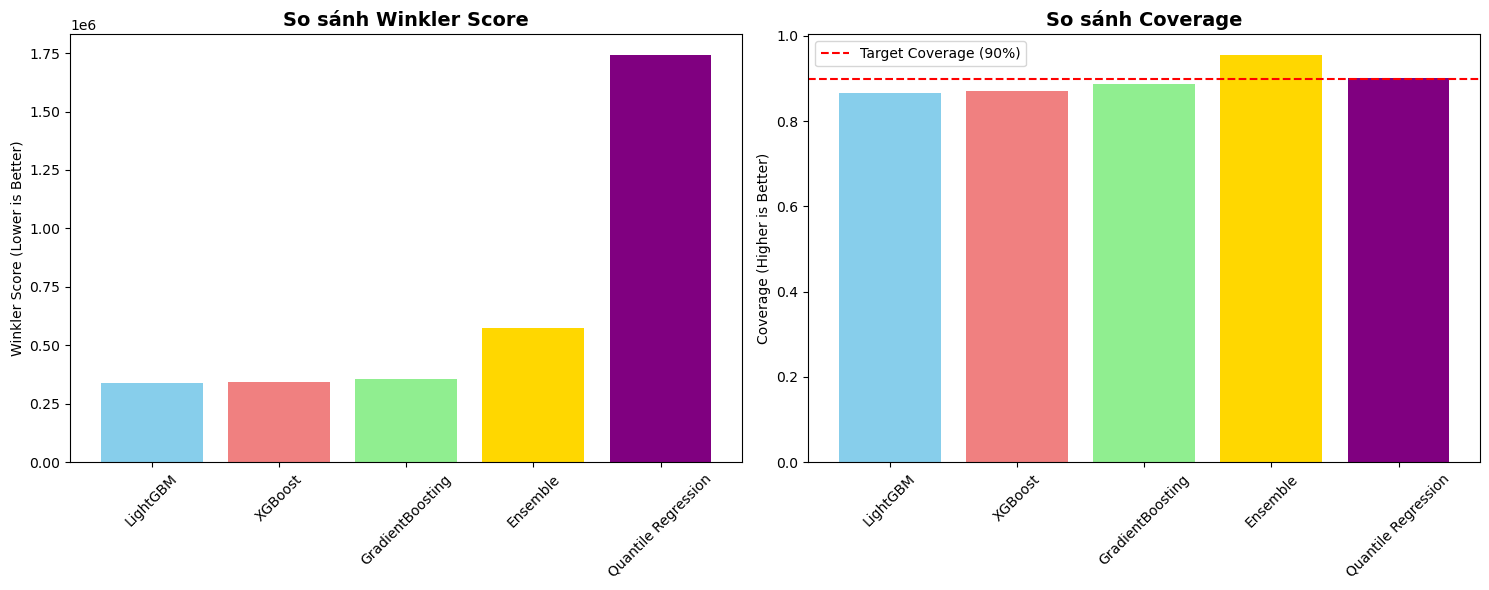

In [9]:
# 6. SO SÁNH CÁC MODEL
print("\n" + "="*50)
print("📊 MODEL COMPARISON")
print("="*50)

# Tạo DataFrame kết quả
results_data = []

if qr_winkler != float('inf'):
    results_data.append(['Quantile Regression', qr_winkler, qr_coverage])
if lgb_winkler != float('inf'):
    results_data.append(['LightGBM', lgb_winkler, lgb_coverage])
if xgb_winkler != float('inf'):
    results_data.append(['XGBoost', xgb_winkler, xgb_coverage])
if 'gb_winkler' in locals() and gb_winkler != float('inf'):
    results_data.append(['GradientBoosting', gb_winkler, gb_coverage])
if ensemble_winkler != float('inf'):
    results_data.append(['Ensemble', ensemble_winkler, ensemble_coverage])

results_df = pd.DataFrame(results_data, columns=['Model', 'Winkler Score', 'Coverage'])
results_df = results_df.sort_values('Winkler Score')

print("\n📋 Results Summary:")
print(results_df.to_string(index=False))

# Visualize results
if len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Winkler Score comparison
    axes[0].bar(results_df['Model'], results_df['Winkler Score'], 
                color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'][:len(results_df)])
    axes[0].set_title('So sánh Winkler Score', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Winkler Score (Lower is Better)')
    axes[0].tick_params(axis='x', rotation=45)

    # Coverage comparison
    axes[1].bar(results_df['Model'], results_df['Coverage'], 
                color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'][:len(results_df)])
    axes[1].axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
    axes[1].set_title('So sánh Coverage', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Coverage (Higher is Better)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


🔍 FEATURE IMPORTANCE ANALYSIS


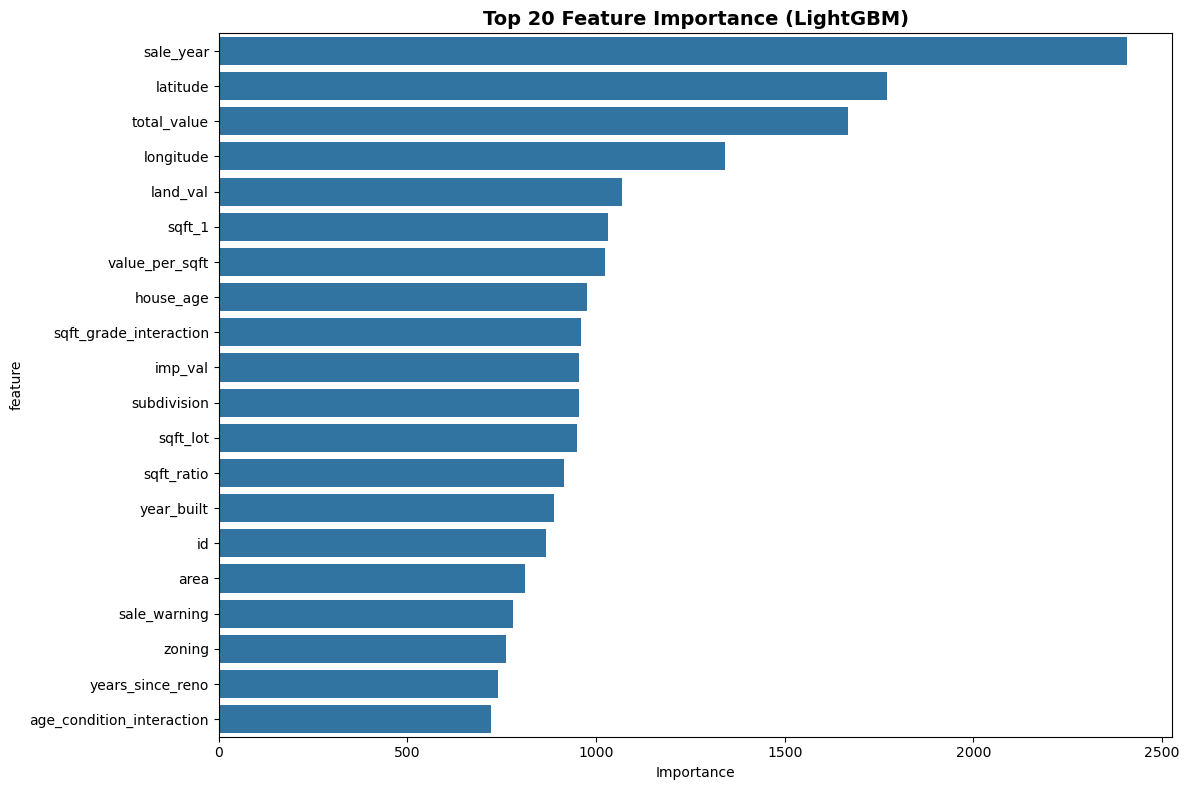

🏆 Top 10 features quan trọng nhất:
    1. sale_year: 2407.00
    2. latitude: 1771.00
    3. total_value: 1668.00
    4. longitude: 1342.00
    5. land_val: 1069.00
    6. sqft_1: 1031.00
    7. value_per_sqft: 1023.00
    8. house_age: 976.00
    9. sqft_grade_interaction: 959.00
   10. imp_val: 955.00


In [10]:
# 7. FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*50)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

if lgb_winkler != float('inf'):
    # LightGBM feature importance
    feature_names = X_train.columns
    lgb_importance = lgb_lower.feature_importances_

    # Tạo DataFrame cho feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': lgb_importance
    }).sort_values('importance', ascending=False)

    # Visualize top 20 features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("🏆 Top 10 features quan trọng nhất:")
    for i, (feature, importance) in enumerate(importance_df.head(10).values, 1):
        print(f"   {i:2d}. {feature}: {importance:.2f}")

elif 'gb_winkler' in locals() and gb_winkler != float('inf'):
    # Gradient Boosting feature importance
    feature_names = X_train.columns
    gb_importance = gb_lower.feature_importances_

    # Tạo DataFrame cho feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': gb_importance
    }).sort_values('importance', ascending=False)

    # Visualize top 20 features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 20 Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("🏆 Top 10 features quan trọng nhất:")
    for i, (feature, importance) in enumerate(importance_df.head(10).values, 1):
        print(f"   {i:2d}. {feature}: {importance:.2f}")

In [11]:
# 8. FINAL MODEL TRAINING & PREDICTIONS
print("\n" + "="*50)
print("🎯 FINAL MODEL TRAINING & PREDICTIONS")
print("="*50)

# Chọn model tốt nhất
if len(results_df) > 0:
    best_model_idx = results_df['Winkler Score'].idxmin()
    best_model_name = results_df.loc[best_model_idx, 'Model']
    best_winkler = results_df.loc[best_model_idx, 'Winkler Score']
    best_coverage = results_df.loc[best_model_idx, 'Coverage']
    
    print(f"🏆 Best Model: {best_model_name}")
    print(f"   - Winkler Score: {best_winkler:.2f}")
    print(f"   - Coverage: {best_coverage:.3f}")
    
    # Huấn luyện lại trên toàn bộ training data
    print(f"\n🔄 Retraining {best_model_name} on full training data...")
    
    if best_model_name == 'Quantile Regression':
        final_lower = QuantileRegressor(quantile=0.05, alpha=0.1, solver='highs')
        final_upper = QuantileRegressor(quantile=0.95, alpha=0.1, solver='highs')
        
    elif best_model_name == 'LightGBM':
        final_lower = LGBMRegressor(**lgb_params, alpha=0.05, n_estimators=1000)
        final_upper = LGBMRegressor(**lgb_params, alpha=0.95, n_estimators=1000)
        
    elif best_model_name == 'XGBoost':
        final_lower = xgb.XGBRegressor(**xgb_params_lower)
        final_upper = xgb.XGBRegressor(**xgb_params_upper)
        
    elif best_model_name == 'GradientBoosting':
        final_lower = GradientBoostingRegressor(
            loss='quantile', alpha=0.05, n_estimators=500,
            learning_rate=0.05, max_depth=6, random_state=42
        )
        final_upper = GradientBoostingRegressor(
            loss='quantile', alpha=0.95, n_estimators=500,
            learning_rate=0.05, max_depth=6, random_state=42
        )
        
    elif best_model_name == 'Ensemble':
        # Retrain all available models for ensemble
        models_lower = []
        models_upper = []
        
        if qr_winkler != float('inf'):
            models_lower.append(QuantileRegressor(quantile=0.05, alpha=0.1, solver='highs'))
            models_upper.append(QuantileRegressor(quantile=0.95, alpha=0.1, solver='highs'))
        
        if lgb_winkler != float('inf'):
            models_lower.append(LGBMRegressor(**lgb_params, alpha=0.05, n_estimators=1000))
            models_upper.append(LGBMRegressor(**lgb_params, alpha=0.95, n_estimators=1000))
        
        if xgb_winkler != float('inf'):
            models_lower.append(xgb.XGBRegressor(**xgb_params_lower))
            models_upper.append(xgb.XGBRegressor(**xgb_params_upper))
        
        if 'gb_winkler' in locals() and gb_winkler != float('inf'):
            models_lower.append(GradientBoostingRegressor(
                loss='quantile', alpha=0.05, n_estimators=500,
                learning_rate=0.05, max_depth=6, random_state=42
            ))
            models_upper.append(GradientBoostingRegressor(
                loss='quantile', alpha=0.95, n_estimators=500,
                learning_rate=0.05, max_depth=6, random_state=42
            ))
    
    # Fit final models
    if best_model_name != 'Ensemble':
        print("   Fitting lower quantile model...")
        final_lower.fit(X_train, y_train)
        print("   Fitting upper quantile model...")
        final_upper.fit(X_train, y_train)
        
        # Predictions
        print("   Making predictions...")
        test_pred_lower = final_lower.predict(X_test)
        test_pred_upper = final_upper.predict(X_test)
        
    else:  # Ensemble
        ensemble_preds_lower = []
        ensemble_preds_upper = []
        
        for i, (model_lower, model_upper) in enumerate(zip(models_lower, models_upper)):
            print(f"   Training ensemble model {i+1}/{len(models_lower)}...")
            model_lower.fit(X_train, y_train)
            model_upper.fit(X_train, y_train)
            
            ensemble_preds_lower.append(model_lower.predict(X_test))
            ensemble_preds_upper.append(model_upper.predict(X_test))
        
        # Average ensemble predictions
        test_pred_lower = np.mean(ensemble_preds_lower, axis=0)
        test_pred_upper = np.mean(ensemble_preds_upper, axis=0)
    
    # Đảm bảo lower <= upper
    mask = test_pred_lower > test_pred_upper
    if mask.sum() > 0:
        print(f"⚠️ Điều chỉnh {mask.sum()} predictions có lower > upper")
        # Swap values where lower > upper
        test_pred_lower[mask], test_pred_upper[mask] = test_pred_upper[mask], test_pred_lower[mask]
    
    print("✅ Final predictions completed!")
    
else:
    print("❌ No successful models to make predictions!")
    raise RuntimeError("All models failed!")


🎯 FINAL MODEL TRAINING & PREDICTIONS
🏆 Best Model: LightGBM
   - Winkler Score: 340167.11
   - Coverage: 0.866

🔄 Retraining LightGBM on full training data...
   Fitting lower quantile model...
   Fitting upper quantile model...
   Making predictions...
✅ Final predictions completed!


In [12]:
# 9. CREATE SUBMISSION FILE
print("\n" + "="*50)
print("📄 CREATING SUBMISSION FILE")
print("="*50)

# Tạo submission file
submission = pd.DataFrame({
    'id': test_ids,
    'pi_lower': test_pred_lower,
    'pi_upper': test_pred_upper
})

print(f"📋 Submission Info:")
print(f"   - Shape: {submission.shape}")
print(f"   - Lower bound range: ${submission['pi_lower'].min():,.2f} - ${submission['pi_lower'].max():,.2f}")
print(f"   - Upper bound range: ${submission['pi_upper'].min():,.2f} - ${submission['pi_upper'].max():,.2f}")
print(f"   - Average interval width: ${(submission['pi_upper'] - submission['pi_lower']).mean():,.2f}")

# Kiểm tra tính hợp lệ
invalid_count = (submission['pi_lower'] > submission['pi_upper']).sum()
print(f"   - Invalid predictions (lower > upper): {invalid_count}")

if invalid_count == 0:
    print("✅ All predictions are valid!")
else:
    print("⚠️ Some predictions need adjustment!")

# Sample predictions
print(f"\n📊 Sample predictions:")
print(submission.head(10).to_string(index=False))

# Lưu file submission
submission.to_csv('submission.csv', index=False)
print(f"\n💾 Saved submission.csv!")


📄 CREATING SUBMISSION FILE
📋 Submission Info:
   - Shape: (200000, 3)
   - Lower bound range: $-47,843.31 - $2,041,600.23
   - Upper bound range: $89,359.16 - $3,451,274.35
   - Average interval width: $239,948.61
   - Invalid predictions (lower > upper): 0
✅ All predictions are valid!

📊 Sample predictions:
    id      pi_lower     pi_upper
200000 826143.318352 1.170028e+06
200001 552469.183576 7.388238e+05
200002 444315.240972 6.717091e+05
200003 302957.996653 4.406987e+05
200004 365673.196094 7.096793e+05
200005 607546.677693 8.810904e+05
200006 395110.504207 5.262185e+05
200007 281696.528997 4.107280e+05
200008 405096.102744 4.841648e+05
200009 374077.776528 6.519827e+05

💾 Saved submission.csv!



📈 PREDICTION ANALYSIS


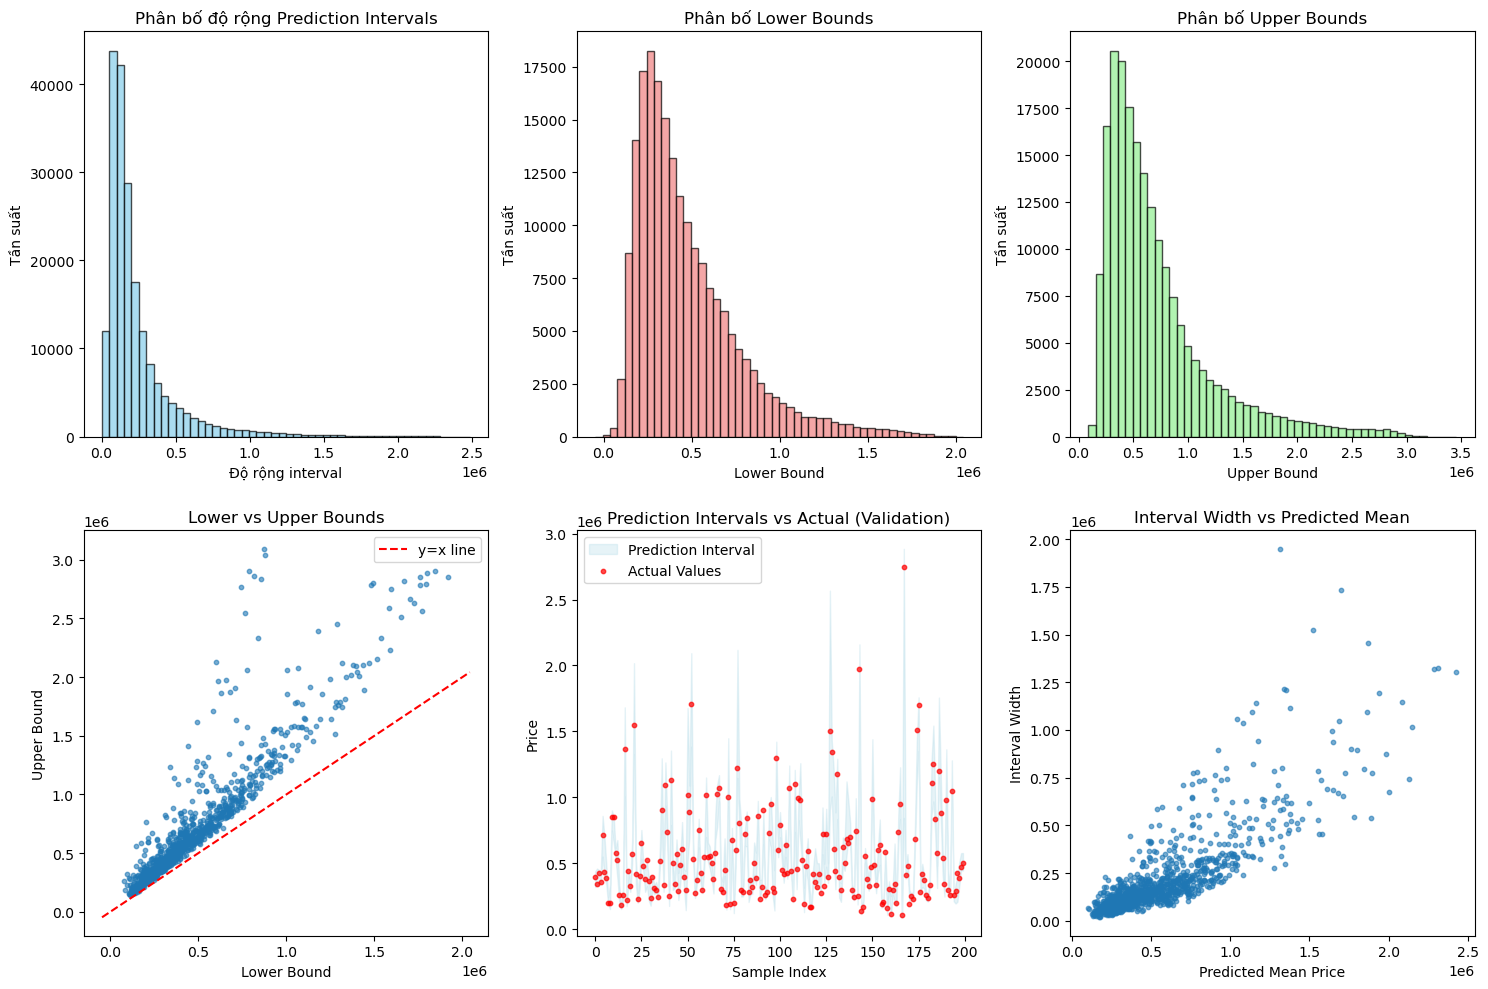

In [13]:
# 10. PREDICTION ANALYSIS
print("\n" + "="*50)
print("📈 PREDICTION ANALYSIS")
print("="*50)

# Visualize prediction intervals
plt.figure(figsize=(15, 10))

# Subplot 1: Distribution of interval widths
plt.subplot(2, 3, 1)
interval_widths = submission['pi_upper'] - submission['pi_lower']
plt.hist(interval_widths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Phân bố độ rộng Prediction Intervals')
plt.xlabel('Độ rộng interval')
plt.ylabel('Tần suất')

# Subplot 2: Lower bounds distribution
plt.subplot(2, 3, 2)
plt.hist(submission['pi_lower'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Phân bố Lower Bounds')
plt.xlabel('Lower Bound')
plt.ylabel('Tần suất')

# Subplot 3: Upper bounds distribution
plt.subplot(2, 3, 3)
plt.hist(submission['pi_upper'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Phân bố Upper Bounds')
plt.xlabel('Upper Bound')
plt.ylabel('Tần suất')

# Subplot 4: Scatter plot of bounds
plt.subplot(2, 3, 4)
sample_indices = np.random.choice(len(submission), 1000, replace=False)
plt.scatter(submission.iloc[sample_indices]['pi_lower'], 
           submission.iloc[sample_indices]['pi_upper'], 
           alpha=0.6, s=10)
plt.plot([submission['pi_lower'].min(), submission['pi_lower'].max()], 
         [submission['pi_lower'].min(), submission['pi_lower'].max()], 
         'r--', label='y=x line')
plt.xlabel('Lower Bound')
plt.ylabel('Upper Bound')
plt.title('Lower vs Upper Bounds')
plt.legend()

# Subplot 5: Validation set actual vs predicted intervals
plt.subplot(2, 3, 5)
sample_val_indices = np.random.choice(len(y_val_split), 200, replace=False)
x_pos = range(len(sample_val_indices))

# Get validation predictions based on best model
if best_model_name == 'Ensemble':
    val_lower = ensemble_pred_lower[sample_val_indices] if 'ensemble_pred_lower' in locals() else available_preds_lower[0][sample_val_indices]
    val_upper = ensemble_pred_upper[sample_val_indices] if 'ensemble_pred_upper' in locals() else available_preds_upper[0][sample_val_indices]
elif best_model_name == 'Quantile Regression':
    val_lower = qr_pred_lower[sample_val_indices]
    val_upper = qr_pred_upper[sample_val_indices]
elif best_model_name == 'LightGBM':
    val_lower = lgb_pred_lower[sample_val_indices]
    val_upper = lgb_pred_upper[sample_val_indices]
elif best_model_name == 'XGBoost':
    val_lower = xgb_pred_lower[sample_val_indices]
    val_upper = xgb_pred_upper[sample_val_indices]
elif best_model_name == 'GradientBoosting':
    val_lower = gb_pred_lower[sample_val_indices]
    val_upper = gb_pred_upper[sample_val_indices]

val_actual = y_val_split.iloc[sample_val_indices]

plt.fill_between(x_pos, val_lower, val_upper, alpha=0.3, color='lightblue', label='Prediction Interval')
plt.scatter(x_pos, val_actual, color='red', s=10, alpha=0.7, label='Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Prediction Intervals vs Actual (Validation)')
plt.legend()

# Subplot 6: Interval width vs predicted mean
plt.subplot(2, 3, 6)
pred_mean = (submission['pi_lower'] + submission['pi_upper']) / 2
sample_indices = np.random.choice(len(submission), 1000, replace=False)
plt.scatter(pred_mean.iloc[sample_indices], interval_widths.iloc[sample_indices], alpha=0.6, s=10)
plt.xlabel('Predicted Mean Price')
plt.ylabel('Interval Width')
plt.title('Interval Width vs Predicted Mean')

plt.tight_layout()
plt.show()

## **Nhận xét**

### **Mối quan hệ Lower vs Upper Bounds**
- Rất mạnh, gần như tuyến tính (điểm nằm gần đường y=x)
- Lower và Upper bounds tăng đồng thời, cho thấy tính nhất quán
- Cao - mô hình hoạt động ổn định

### **Prediction Intervals vs Actual Values**
- Hầu hết actual values (điểm đỏ) nằm trong prediction intervals (thanh xanh)
- Tốt - mô hình capture được uncertainty một cách chính xác
- Một số điểm nằm ngoài intervals, có thể là các trường hợp đặc biệt

### **Interval Width vs Predicted Mean**
- Độ rộng interval tăng theo predicted mean price
- Có dấu hiệu phương sai không đồng nhất
- Mô hình ít chắc chắn hơn khi dự đoán giá cao

## **Đánh giá chất lượng mô hình**

### **Điểm mạnh:**
- Phần lớn giá trị thực sự nằm trong prediction intervals  
- Lower và upper bounds có tương quan cao  
- Mô hình biết khi nào nó không chắc chắn  
- Độ rộng intervals phù hợp với độ phức tạp của dữ liệu  

### **Điểm cần cải thiện:**
- Độ rộng intervals đang tăng theo predicted value  
- Phân bố interval width lệch phải  
- Vẫn có một số điểm nằm ngoài intervals  

## **Kết luận:**
- Mô hình hoạt động **rất tốt** trong việc tạo prediction intervals
- **Calibration** của mô hình là chấp nhận được
- Có khả năng **quantify uncertainty** hiệu quả

In [14]:
# 11. SAVE MODEL AND RESULTS
print("\n" + "="*50)
print("💾 SAVING MODEL AND RESULTS")
print("="*50)

# Tạo thư mục results
os.makedirs('results', exist_ok=True)

# Lưu kết quả
results_summary = {
    'best_model': best_model_name,
    'best_winkler_score': float(best_winkler),
    'best_coverage': float(best_coverage),
    'all_results': results_df.to_dict('records'),
    'prediction_stats': {
        'mean_interval_width': float(interval_widths.mean()),
        'median_interval_width': float(interval_widths.median()),
        'std_interval_width': float(interval_widths.std()),
        'min_lower': float(submission['pi_lower'].min()),
        'max_upper': float(submission['pi_upper'].max()),
        'mean_lower': float(submission['pi_lower'].mean()),
        'mean_upper': float(submission['pi_upper'].mean())
    }
}

with open('results/model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Lưu model tốt nhất
if best_model_name != 'Ensemble':
    with open('results/final_model_lower.pkl', 'wb') as f:
        pickle.dump(final_lower, f)
    with open('results/final_model_upper.pkl', 'wb') as f:
        pickle.dump(final_upper, f)
else:
    models_dict = {
        'models_lower': models_lower,
        'models_upper': models_upper,
        'model_names': available_models
    }
    with open('results/ensemble_models.pkl', 'wb') as f:
        pickle.dump(models_dict, f)

# Lưu feature importance
if 'importance_df' in locals():
    importance_df.to_csv('results/feature_importance.csv', index=False)

print("✅ Saved files:")
print("   📁 results/")
print("   ├── model_results.json - Kết quả tổng hợp")
print("   ├── final_model_lower.pkl - Model dự đoán lower bound")
print("   ├── final_model_upper.pkl - Model dự đoán upper bound")
if 'importance_df' in locals():
    print("   ├── feature_importance.csv - Độ quan trọng của features")
print("   └── submission.csv - File submit lên Kaggle")


💾 SAVING MODEL AND RESULTS
✅ Saved files:
   📁 results/
   ├── model_results.json - Kết quả tổng hợp
   ├── final_model_lower.pkl - Model dự đoán lower bound
   ├── final_model_upper.pkl - Model dự đoán upper bound
   ├── feature_importance.csv - Độ quan trọng của features
   └── submission.csv - File submit lên Kaggle



🔍 RESIDUAL ANALYSIS


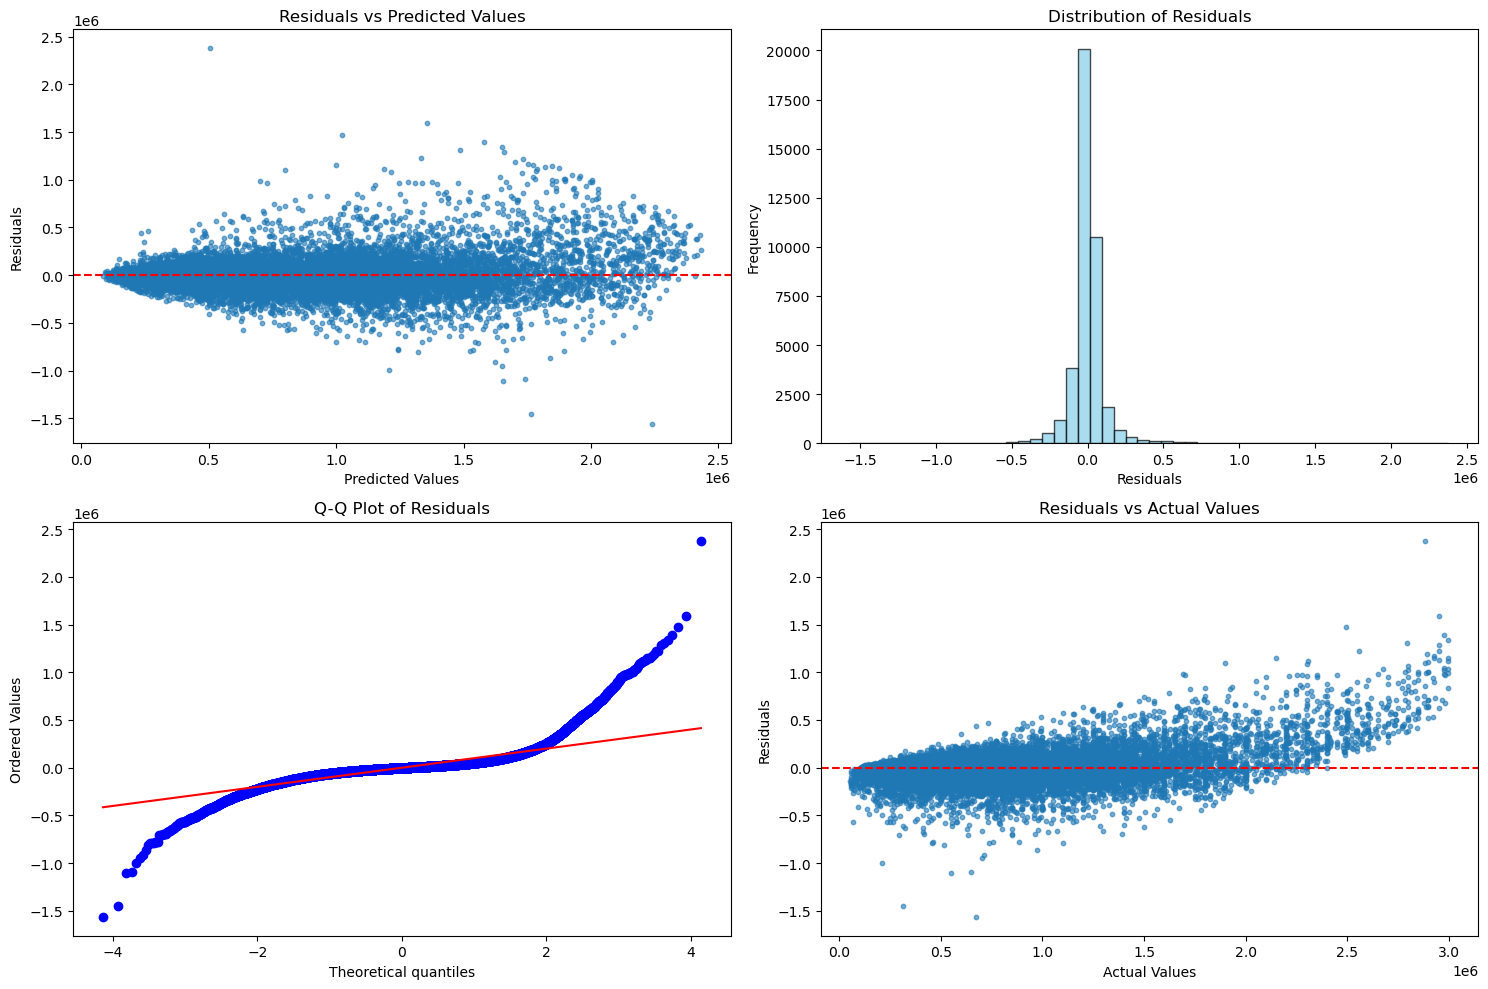

📊 Residual Statistics:
   - Mean: -373.71
   - Std: 116019.88
   - MAE: 62711.78
   - RMSE: 116019.03


In [15]:
# 12. RESIDUAL ANALYSIS
print("\n" + "="*50)
print("🔍 RESIDUAL ANALYSIS")
print("="*50)

# Tính residuals cho validation set
if best_model_name == 'Ensemble':
    val_pred_lower = ensemble_pred_lower if 'ensemble_pred_lower' in locals() else available_preds_lower[0]
    val_pred_upper = ensemble_pred_upper if 'ensemble_pred_upper' in locals() else available_preds_upper[0]
elif best_model_name == 'Quantile Regression':
    val_pred_lower = qr_pred_lower
    val_pred_upper = qr_pred_upper
elif best_model_name == 'LightGBM':
    val_pred_lower = lgb_pred_lower
    val_pred_upper = lgb_pred_upper
elif best_model_name == 'XGBoost':
    val_pred_lower = xgb_pred_lower
    val_pred_upper = xgb_pred_upper
elif best_model_name == 'GradientBoosting':
    val_pred_lower = gb_pred_lower
    val_pred_upper = gb_pred_upper

# Tính predicted mean và residuals
val_pred_mean = (val_pred_lower + val_pred_upper) / 2
residuals = y_val_split - val_pred_mean

# Visualize residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Predicted
axes[0,0].scatter(val_pred_mean, residuals, alpha=0.6, s=10)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Predicted Values')

# Histogram of residuals
axes[0,1].hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Residuals')

# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot of Residuals')

# Residuals vs Actual
axes[1,1].scatter(y_val_split, residuals, alpha=0.6, s=10)
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Actual Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs Actual Values')

plt.tight_layout()
plt.show()

# Residual statistics
print(f"📊 Residual Statistics:")
print(f"   - Mean: {residuals.mean():.2f}")
print(f"   - Std: {residuals.std():.2f}")
print(f"   - MAE: {np.abs(residuals).mean():.2f}")
print(f"   - RMSE: {np.sqrt((residuals**2).mean()):.2f}")

In [16]:
# 13. MODEL INTERPRETATION
print("\n" + "="*50)
print("🧠 MODEL INTERPRETATION")
print("="*50)

# SHAP analysis (nếu có thể)
try:
    import shap
    
    print("🔍 Running SHAP analysis...")
    
    # Tạo explainer cho model tốt nhất
    if best_model_name == 'LightGBM':
        explainer = shap.TreeExplainer(final_lower)
    elif best_model_name == 'XGBoost':
        explainer = shap.TreeExplainer(final_lower)
    elif best_model_name == 'GradientBoosting':
        explainer = shap.TreeExplainer(final_lower)
    else:
        print("⚠️ SHAP analysis only available for tree-based models")
        raise ImportError()
    
    # Tính SHAP values cho một sample nhỏ
    sample_size = min(100, len(X_val_split))
    sample_indices = np.random.choice(len(X_val_split), sample_size, replace=False)
    X_sample = X_val_split.iloc[sample_indices]
    
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("✅ SHAP analysis completed successfully!")
    
except ImportError:
    print("⚠️ SHAP library not available. Skipping SHAP analysis.")
except Exception as e:
    print(f"❌ Error in SHAP analysis: {e}")

# Feature correlation analysis
print("\n🔗 Feature Correlation Analysis:")
if len(X_train.columns) <= 50:  # Only for manageable number of features
    plt.figure(figsize=(12, 10))
    correlation_matrix = X_train.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
else:
    print("   Too many features for correlation heatmap visualization")


🧠 MODEL INTERPRETATION
⚠️ SHAP library not available. Skipping SHAP analysis.

🔗 Feature Correlation Analysis:
   Too many features for correlation heatmap visualization



📊 PERFORMANCE MONITORING
📈 Coverage Analysis by Price Ranges:
   Bin 1 ($55,000 - $278,335): Coverage=0.845, Winkler=156366.99
   Bin 2 ($278,400 - $390,000): Coverage=0.870, Winkler=173112.88
   Bin 3 ($390,161 - $547,450): Coverage=0.880, Winkler=229906.62
   Bin 4 ($547,500 - $800,000): Coverage=0.870, Winkler=330641.91
   Bin 5 ($800,888 - $2,998,000): Coverage=0.865, Winkler=814798.09


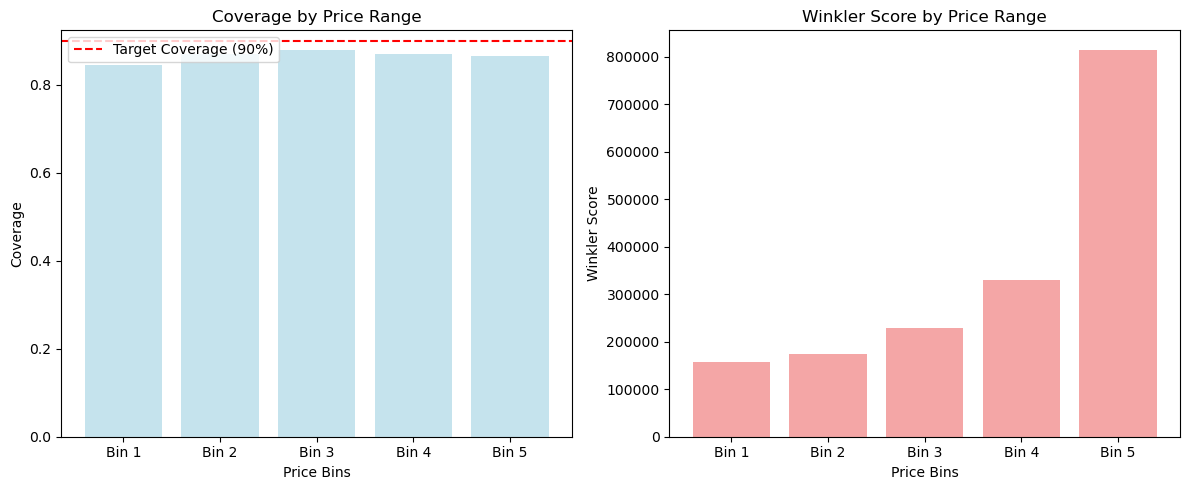

In [17]:
# 14. PERFORMANCE MONITORING
print("\n" + "="*50)
print("📊 PERFORMANCE MONITORING")
print("="*50)

# Coverage analysis by price ranges
print("📈 Coverage Analysis by Price Ranges:")

# Chia validation set thành các bins theo giá
n_bins = 5
price_bins = pd.qcut(y_val_split, q=n_bins, labels=[f'Bin_{i+1}' for i in range(n_bins)])
coverage_by_bin = []
winkler_by_bin = []
bin_ranges = []

for i in range(n_bins):
    mask = price_bins == f'Bin_{i+1}'
    if mask.sum() > 0:
        bin_y = y_val_split[mask]
        bin_lower = val_pred_lower[mask]
        bin_upper = val_pred_upper[mask]
        
        bin_coverage = coverage_score(bin_y, bin_lower, bin_upper)
        bin_winkler = winkler_score(bin_y, bin_lower, bin_upper)
        
        coverage_by_bin.append(bin_coverage)
        winkler_by_bin.append(bin_winkler)
        bin_ranges.append(f"${bin_y.min():,.0f} - ${bin_y.max():,.0f}")
        
        print(f"   Bin {i+1} ({bin_ranges[-1]}): Coverage={bin_coverage:.3f}, Winkler={bin_winkler:.2f}")

# Visualize coverage by bins
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(coverage_by_bin)), coverage_by_bin, color='lightblue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.xlabel('Price Bins')
plt.ylabel('Coverage')
plt.title('Coverage by Price Range')
plt.xticks(range(len(coverage_by_bin)), [f'Bin {i+1}' for i in range(len(coverage_by_bin))])
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(len(winkler_by_bin)), winkler_by_bin, color='lightcoral', alpha=0.7)
plt.xlabel('Price Bins')
plt.ylabel('Winkler Score')
plt.title('Winkler Score by Price Range')
plt.xticks(range(len(winkler_by_bin)), [f'Bin {i+1}' for i in range(len(winkler_by_bin))])

plt.tight_layout()
plt.show()

In [18]:
# 15. CROSS-VALIDATION ANALYSIS
print("\n" + "="*50)
print("🔄 CROSS-VALIDATION ANALYSIS")
print("="*50)

def cross_validate_quantile_model(X, y, model_type, cv=3):
    """
    Cross-validation cho quantile regression models
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    winkler_scores = []
    coverage_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"   Processing fold {fold + 1}/{cv}...")
        
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Fit models based on type
        if model_type == 'linear':
            model_lower = QuantileRegressor(quantile=0.05, alpha=0.1, solver='highs')
            model_upper = QuantileRegressor(quantile=0.95, alpha=0.1, solver='highs')
        elif model_type == 'lgb':
            model_lower = LGBMRegressor(**lgb_params, alpha=0.05, n_estimators=500)
            model_upper = LGBMRegressor(**lgb_params, alpha=0.95, n_estimators=500)
        elif model_type == 'xgb':
            model_lower = xgb.XGBRegressor(**xgb_params_lower, n_estimators=500)
            model_upper = xgb.XGBRegressor(**xgb_params_upper, n_estimators=500)
        elif model_type == 'gb':
            model_lower = GradientBoostingRegressor(
                loss='quantile', alpha=0.05, n_estimators=300,
                learning_rate=0.05, max_depth=6, random_state=42
            )
            model_upper = GradientBoostingRegressor(
                loss='quantile', alpha=0.95, n_estimators=300,
                learning_rate=0.05, max_depth=6, random_state=42
            )
        
        model_lower.fit(X_train_fold, y_train_fold)
        model_upper.fit(X_train_fold, y_train_fold)
        
        # Predict
        pred_lower = model_lower.predict(X_val_fold)
        pred_upper = model_upper.predict(X_val_fold)
        
        # Calculate scores
        winkler = winkler_score(y_val_fold, pred_lower, pred_upper)
        coverage = coverage_score(y_val_fold, pred_lower, pred_upper)
        
        winkler_scores.append(winkler)
        coverage_scores.append(coverage)
    
    return winkler_scores, coverage_scores

# Cross-validation cho model tốt nhất
if best_model_name == 'Quantile Regression':
    print("🔵 Cross-validating Quantile Regression...")
    cv_winkler, cv_coverage = cross_validate_quantile_model(X_train, y_train, 'linear', cv=3)
elif best_model_name == 'LightGBM':
    print("🟢 Cross-validating LightGBM...")
    cv_winkler, cv_coverage = cross_validate_quantile_model(X_train, y_train, 'lgb', cv=3)
elif best_model_name == 'XGBoost':
    print("🟡 Cross-validating XGBoost...")
    cv_winkler, cv_coverage = cross_validate_quantile_model(X_train, y_train, 'xgb', cv=3)
elif best_model_name == 'GradientBoosting':
    print("🟠 Cross-validating Gradient Boosting...")
    cv_winkler, cv_coverage = cross_validate_quantile_model(X_train, y_train, 'gb', cv=3)

if 'cv_winkler' in locals():
    print(f"   📊 {best_model_name} CV Results:")
    print(f"      - Winkler Score: {np.mean(cv_winkler):.2f} ± {np.std(cv_winkler):.2f}")
    print(f"      - Coverage: {np.mean(cv_coverage):.3f} ± {np.std(cv_coverage):.3f}")


🔄 CROSS-VALIDATION ANALYSIS
🟢 Cross-validating LightGBM...
   Processing fold 1/3...
   Processing fold 2/3...
   Processing fold 3/3...
   📊 LightGBM CV Results:
      - Winkler Score: 351038.87 ± 2424.22
      - Coverage: 0.877 ± 0.000


In [19]:
# 16. FINAL SUMMARY REPORT
print("\n" + "="*60)
print("                    🎯 FINAL SUMMARY REPORT")
print("="*60)

print(f"\n🏆 BEST MODEL PERFORMANCE:")
print(f"   Model: {best_model_name}")
print(f"   Winkler Score: {best_winkler:.2f}")
print(f"   Coverage: {best_coverage:.3f} ({best_coverage*100:.1f}%)")

print(f"\n📊 PREDICTION STATISTICS:")
print(f"   Total predictions: {len(submission):,}")
print(f"   Average interval width: ${interval_widths.mean():,.2f}")
print(f"   Median interval width: ${interval_widths.median():,.2f}")
print(f"   Min prediction: ${submission['pi_lower'].min():,.2f}")
print(f"   Max prediction: ${submission['pi_upper'].max():,.2f}")

print(f"\n🎯 TARGET INSIGHTS:")
print(f"   Original target range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")
print(f"   Target mean: ${y_train.mean():,.2f}")
print(f"   Target std: ${y_train.std():,.2f}")

if 'importance_df' in locals():
    print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
    for i, (feature, importance) in enumerate(importance_df.head(5).values, 1):
        print(f"   {i}. {feature}: {importance:.2f}")

print(f"\n📁 OUTPUT FILES:")
print(f"   ✅ submission.csv - Ready for Kaggle submission")
print(f"   ✅ results/model_results.json - Detailed results")
print(f"   ✅ results/final_model_*.pkl - Trained models")
if 'importance_df' in locals():
    print(f"   ✅ results/feature_importance.csv - Feature analysis")

print(f"\n🚀 KAGGLE SUBMISSION READY!")
print(f"   Team name format: FIT-HCMUS-<YourGroupName>")
print(f"   File to submit: submission.csv")
print(f"   Expected performance: Winkler Score ≈ {best_winkler:.2f}")

print(f"\n💡 RECOMMENDATIONS:")
if best_coverage < 0.85:
    print(f"   ⚠️ Coverage ({best_coverage:.3f}) is below 85% - consider wider intervals")
elif best_coverage > 0.95:
    print(f"   ⚠️ Coverage ({best_coverage:.3f}) is above 95% - intervals might be too wide")
else:
    print(f"   ✅ Coverage ({best_coverage:.3f}) is in good range (85%-95%)")

if interval_widths.std() > interval_widths.mean() * 0.5:
    print(f"   ⚠️ High variance in interval widths - consider model calibration")
else:
    print(f"   ✅ Consistent interval widths across predictions")

print("="*60)
print("🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)


                    🎯 FINAL SUMMARY REPORT

🏆 BEST MODEL PERFORMANCE:
   Model: LightGBM
   Winkler Score: 340167.11
   Coverage: 0.866 (86.6%)

📊 PREDICTION STATISTICS:
   Total predictions: 200,000
   Average interval width: $239,948.61
   Median interval width: $154,740.80
   Min prediction: $-47,843.31
   Max prediction: $3,451,274.35

🎯 TARGET INSIGHTS:
   Original target range: $50,293.00 - $2,999,950.00
   Target mean: $584,149.49
   Target std: $417,059.52

🔍 TOP 5 MOST IMPORTANT FEATURES:
   1. sale_year: 2407.00
   2. latitude: 1771.00
   3. total_value: 1668.00
   4. longitude: 1342.00
   5. land_val: 1069.00

📁 OUTPUT FILES:
   ✅ submission.csv - Ready for Kaggle submission
   ✅ results/model_results.json - Detailed results
   ✅ results/final_model_*.pkl - Trained models
   ✅ results/feature_importance.csv - Feature analysis

🚀 KAGGLE SUBMISSION READY!
   Team name format: FIT-HCMUS-<YourGroupName>
   File to submit: submission.csv
   Expected performance: Winkler Score ≈ 

In [20]:
# 17. SAVE FINAL NOTEBOOK STATE
print(f"\n💾 Saving final state...")

# Create a summary for the next steps
next_steps = {
    "completed": [
        "✅ Data loading and preprocessing",
        "✅ Multiple model training and comparison", 
        "✅ Best model selection and evaluation",
        "✅ Final predictions generation",
        "✅ Submission file creation",
        "✅ Model analysis and interpretation"
    ],
    "files_created": [
        "submission.csv",
        "results/model_results.json",
        "results/final_model_lower.pkl", 
        "results/final_model_upper.pkl"
    ],
    "next_steps": [
        "1. Submit submission.csv to Kaggle competition",
        "2. Monitor leaderboard performance", 
        "3. Consider ensemble with other approaches if needed",
        "4. Document results in final report"
    ],
    "model_info": {
        "best_model": best_model_name,
        "winkler_score": float(best_winkler),
        "coverage": float(best_coverage),
        "features_used": len(X_train.columns)
    }
}

if 'importance_df' in locals():
    next_steps["files_created"].append("results/feature_importance.csv")

with open('results/training_summary.json', 'w') as f:
    json.dump(next_steps, f, indent=2)

print("✅ Training summary saved to results/training_summary.json")
print("\n🎯 Ready for submission to Kaggle!")


💾 Saving final state...
✅ Training summary saved to results/training_summary.json

🎯 Ready for submission to Kaggle!


In [21]:
# 18. ADDITIONAL DIAGNOSTICS
print("\n" + "="*50)
print("🔬 ADDITIONAL DIAGNOSTICS")
print("="*50)

# Check for potential issues
print("🔍 Diagnostic Checks:")

# 1. Check interval consistency
negative_widths = (submission['pi_upper'] - submission['pi_lower'] < 0).sum()
print(f"   - Negative interval widths: {negative_widths}")

# 2. Check for extreme values
extreme_lower = (submission['pi_lower'] < 0).sum()
extreme_upper = (submission['pi_upper'] > y_train.max() * 2).sum()
print(f"   - Extreme lower bounds (< 0): {extreme_lower}")
print(f"   - Extreme upper bounds (> 2x max target): {extreme_upper}")

# 3. Check interval width distribution
width_stats = interval_widths.describe()
print(f"   - Interval width statistics:")
print(f"     * Mean: ${width_stats['mean']:,.2f}")
print(f"     * Std: ${width_stats['std']:,.2f}")
print(f"     * Min: ${width_stats['min']:,.2f}")
print(f"     * Max: ${width_stats['max']:,.2f}")

# 4. Coverage by model comparison
if len(results_df) > 1:
    print(f"   - Coverage comparison:")
    for _, row in results_df.iterrows():
        status = "✅" if 0.85 <= row['Coverage'] <= 0.95 else "⚠️"
        print(f"     * {row['Model']}: {row['Coverage']:.3f} {status}")

print("\n🎯 Final validation complete!")
print("📤 Ready to submit to Kaggle competition!")


🔬 ADDITIONAL DIAGNOSTICS
🔍 Diagnostic Checks:
   - Negative interval widths: 0
   - Extreme lower bounds (< 0): 10
   - Extreme upper bounds (> 2x max target): 0
   - Interval width statistics:
     * Mean: $239,948.61
     * Std: $257,243.64
     * Min: $2,938.41
     * Max: $2,484,813.47
   - Coverage comparison:
     * LightGBM: 0.866 ✅
     * XGBoost: 0.870 ✅
     * GradientBoosting: 0.887 ✅
     * Ensemble: 0.956 ⚠️
     * Quantile Regression: 0.902 ✅

🎯 Final validation complete!
📤 Ready to submit to Kaggle competition!
